
## 🌩️ CloudRiskNet: Detecting High-Risk Weather for Power Grids

Author: Dani Antonini Bromberger

Date: 2026-01-13

Objective: Binary classification of weather images into
            "High Risk" vs "Low Risk" for electrical infrastructure

Dataset: [Weather Dataset by Jehan Bhathena](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset)

Method: Transfer Learning with EfficientNetB0

> 💡 This notebook is shared in **read-only mode**.  
> To experiment, click **File → Save a copy in Drive**.

## **Step 1:** Install and Upgrade Dependencies

In [ ]:
# If kagglehub is outdated, uncomment and run.
#!pip install --upgrade kagglehub

##**Step 2:** Download Dataset from KaggleHub

In [ ]:
# Import required libraries
import kagglehub
import shutil
import os

# Download the latest version of the dataset from Kaggle
# - kagglehub automatically handles authentication for public datasets
# - Returns the local path where the dataset was saved (usually in ~/.cache/kagglehub/)
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

# Print the actual local path for transparency and debugging.
print("Path to dataset files:", path)

# Origin path (from Kagglehub)
source_dir = os.path.join(path, "dataset")

# Destination route
dest_dir = "/content/weather-dataset/dataset"

# Copy the entire dataset from the cache to the destination only if it doesn’t already exist
if not os.path.exists(dest_dir):
    shutil.copytree(source_dir, dest_dir)

# Verify that the dataset was copied correctly by listing its contents
destination_dir = dest_dir
print("\n🔍 Verifying dataset structure:")
try:
    classes = os.listdir(destination_dir)  # Get list of subdirectories (weather classes)
    print(f"Found {len(classes)} weather classes: {sorted(classes)}") # Show count and names
except FileNotFoundError:
    print("❌ Error: Dataset directory not found. Please check the download path.")

Using Colab cache for faster access to the 'weather-dataset' dataset.
Path to dataset files: /kaggle/input/weather-dataset

🔍 Verifying dataset structure:
Found 11 weather classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


### **Step 3:** Reorganize Data into Binary Risk Categories

In [ ]:
# Define risk categories based on impact to power systems
HIGH_RISK_CLASSES = {"hail", "lightning", "rain", "glaze", "sandstorm", "rime", "frost", "snow"}
LOW_RISK_CLASSES = {"dew", "rainbow", "fogsmog"}

# Create output directory structure for binary classification
binary_dir = "/content/weather_binary"
os.makedirs(os.path.join(binary_dir, "High_Risk"), exist_ok=True)
os.makedirs(os.path.join(binary_dir, "Low_Risk"), exist_ok=True)

# Iterate over each weather class folder in the source dataset
for weather_class in os.listdir(source_dir):
    class_path = os.path.join(source_dir, weather_class)
    # Skip if not a directory (e.g., hidden files)
    if not os.path.isdir(class_path):
        continue
    # Assign target folder based on risk category
    if weather_class in HIGH_RISK_CLASSES:
        target_dir = os.path.join(binary_dir, "High_Risk")
    elif weather_class in LOW_RISK_CLASSES:
        target_dir = os.path.join(binary_dir, "Low_Risk")
    else:
        # Notify if a class is not categorized (helps catch new/unexpected classes)
        print(f"Warning: '{weather_class}' not assigned to any risk category.")
        continue
    # Copy all images from source class to target risk folder, preserving
    # Original class in filename
    for img in os.listdir(class_path):
        src = os.path.join(class_path, img)
        dst = os.path.join(target_dir, f"{weather_class}_{img}")
        shutil.copy2(src, dst)

# Confirm the reorganization and display the final counts.
print("✅ Data reorganization complete!")
print("High_Risk samples:", len(os.listdir(os.path.join(binary_dir, "High_Risk"))))
print("Low_Risk samples: ", len(os.listdir(os.path.join(binary_dir, "Low_Risk"))))

✅ Data reorganization complete!
High_Risk samples: 5081
Low_Risk samples:  1781


##✍️ Note on dataset balancing:

The final dataset contains 5,081 high-risk samples and 1,781 low-risk samples (approximately a 2.8:1 ratio). This imbalance indicates the inclusion of several ice and storm-related phenomena (rime, frost, snow, glaze) in the high-risk category, a deliberate choice to prioritize power grid safety. While manageable for training, we will monitor the hit rate during validation to ensure the model does not ignore real-world low-risk conditions.

##**Step 4:** Validate and Visualize Data Distribution

In [ ]:
# Import required libraries
import os
from collections import Counter

# Count occurrences of each original weather class within a risk category folder
def count_original_classes(category_path):
    counts = Counter()
    for filename in os.listdir(category_path):
        # Only process image files
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Extract original class from filename (format: "class_imagename.jpg")
            original_class = filename.split('_')[0]
            counts[original_class] += 1
    return counts

# Display the class distribution in the High_Risk folder.
print("📊 Distribution in High_Risk:")
high_counts = count_original_classes("/content/weather_binary/High_Risk")
for cls, cnt in high_counts.most_common():
    print(f"  {cls}: {cnt}")

# Display class distribution in Low_Risk folder
print("\n📊 Distribution in Low_Risk:")
low_counts = count_original_classes("/content/weather_binary/Low_Risk")
for cls, cnt in low_counts.most_common():
    print(f"  {cls}: {cnt}")

📊 Distribution in High_Risk:
  rime: 1160
  sandstorm: 692
  glaze: 639
  snow: 621
  hail: 591
  rain: 526
  frost: 475
  lightning: 377

📊 Distribution in Low_Risk:
  fogsmog: 851
  dew: 698
  rainbow: 232


### 🎯 Risk Categorization Rationale

We grouped weather phenomena based on their potential impact on power grid infrastructure:

🔴 **High-Risk (5,081 samples)**: Events that can cause mechanical stress, outages, or equipment damage:  
- **rime, frost, glaze** → ice accumulation on power lines  
- **snow** → weight-induced line breakage  
- **hail, lightning, rain** → direct physical damage  
- **sandstorm** → abrasion and short circuits  

🟢 **Low-Risk (1,781 samples)**: Mostly visual or non-disruptive conditions:  
- **dew, rainbow** → minimal operational impact  
- **fogsmog** → included as low-risk but may need re-evaluation in high-humidity scenarios  

⚖️ **Note**: The 2.85:1 class imbalance reflects real-world monitoring priorities — safety-critical systems often emphasize **sensitivity over specificity**.

##**Step 5:** Visualize Sample Images

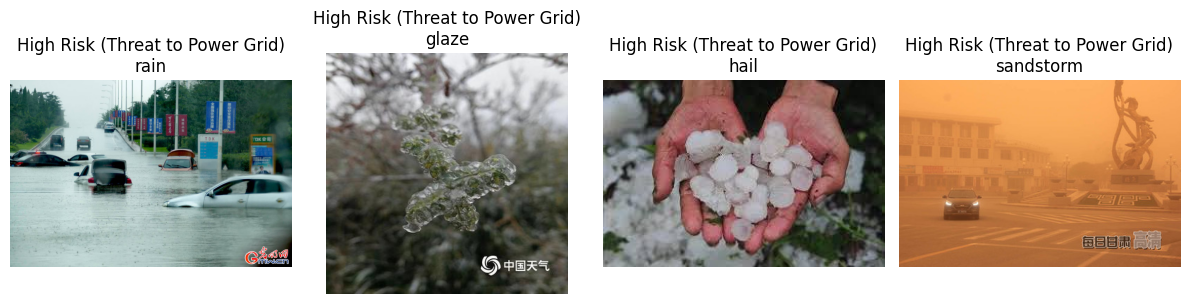

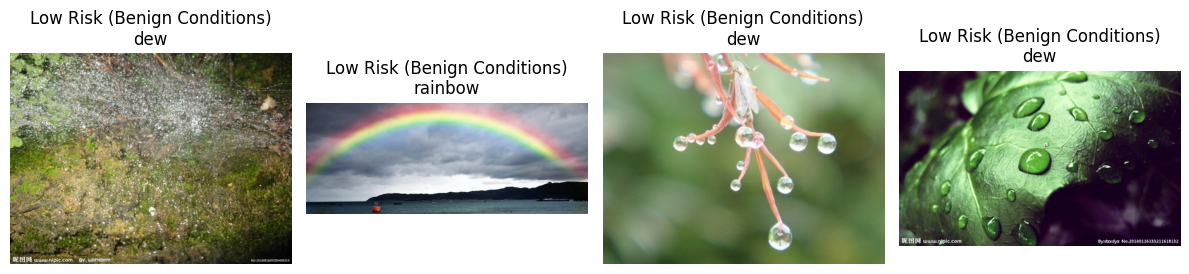

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

# Visualize random sample images from a given risk category
def show_sample_images(category_path, title, num_samples=4):
    # List all .jpg files in the category folder
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg'))]
    # Randomly select up to 'num_samples' images (or fewer if not enough available)
    selected = random.sample(image_files, min(num_samples, len(image_files)))

    # Create a horizontal subplot to display selected images
    plt.figure(figsize=(12, 3))
    for i, img_file in enumerate(selected):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        # Show category title and original weather class (extracted from filename)
        plt.title(f"{title}\n{img_file.split('_')[0]}")  # Extract original weather class
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images for both risk categories
show_sample_images("/content/weather_binary/High_Risk", "High Risk (Threat to Power Grid)")
show_sample_images("/content/weather_binary/Low_Risk", "Low Risk (Benign Conditions)")

 🚨 VISUAL INSPECTION SUMMARY 🚨

 🔴 HIGH RISK: Images show clear threats to infrastructure

    ➤ Rain → floods roads & substations
    ➤ Glaze → ice = weight = broken lines
    ➤ Hail → damaged equipment (equipment breakdown!)
    ➤ Sandstorm → abrasive + conductive dust

 🟢 LOW RISK: Aesthetic or low-impact conditions

    ➤ Dew → pretty droplets, no danger
    ➤ Rainbow → nature’s art, not a storm
    ➤ Frost → light coating, manageable

 🧠 Model Challenge: Some classes look similar

 → good test for generalization!

 🛡️ Our goal: Train model to distinguish subtle but critical differences.

###**Step 5.1:** Validate Data Distribution After Reorganization
######Purpose: Ensure correct assignment of weather classes to risk categories

In [ ]:
# Import required libraries
import os
import glob

# Count total valid image files in each risk category folder
high_risk_dir = "/content/weather_binary/High_Risk"
low_risk_dir = "/content/weather_binary/Low_Risk"

high_risk_count = len([f for f in os.listdir(high_risk_dir) if f.lower().endswith(('.jpg'))])
low_risk_count = len([f for f in os.listdir(low_risk_dir) if f.lower().endswith(('.jpg'))])

# Print final dataset size after reorganization
print(f"📊 Total images after reorganization:")
print(f"   ✅ High Risk: {high_risk_count}")
print(f"   ✅ Low Risk:  {low_risk_count}")

# Verify that key high-risk weather phenomena are present in the dataset
critical_classes = ["rime", "frost", "glaze", "lightning"]
print(f"\n🔍 Verification of critical high-risk phenomena:")

for cls in critical_classes:
    # Use glob to count files matching the pattern "class_*"
    pattern = os.path.join(high_risk_dir, f"{cls}_*")
    count = len(glob.glob(pattern))
    status = "✅ Found" if count > 0 else "❌ Missing"
    print(f"   {cls.capitalize()}: {count} images ({status})")

📊 Total images after reorganization:
   ✅ High Risk: 5081
   ✅ Low Risk:  1781

🔍 Verification of critical high-risk phenomena:
   Rime: 1160 images (✅ Found)
   Frost: 475 images (✅ Found)
   Glaze: 639 images (✅ Found)
   Lightning: 377 images (✅ Found)


###**Step 5.2** Bar Chart of Distributions
Purpose: Visualize the composition of each category with a chart.

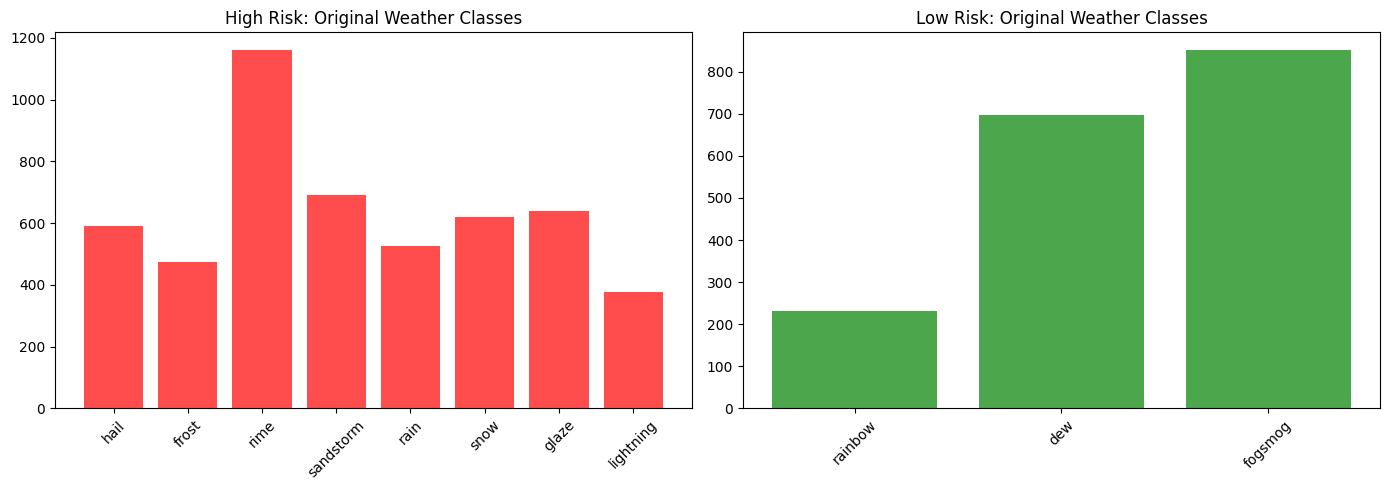

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt

# Plot bar charts showing the distribution of original weather classes in each risk category
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# High Risk category: red bars
ax[0].bar(high_counts.keys(), high_counts.values(), color='red', alpha=0.7)
ax[0].set_title('High Risk: Original Weather Classes')
ax[0].tick_params(axis='x', rotation=45)

# Low Risk category: green bars
ax[1].bar(low_counts.keys(), low_counts.values(), color='green', alpha=0.7)
ax[1].set_title('Low Risk: Original Weather Classes')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 📊 Class Distribution: High-Risk vs Low-Risk Breakdown

🔴 **HIGH RISK (5,081 samples)** — Dominated by ice and storm phenomena:  
- ❄️ **rime (1,160)** → 1 threat → heavy ice accumulation on power lines  
- 🌪️ **sandstorm (692)** → abrasive + conductive dust  
- 💥 **hail (591)** → physical damage to equipment  
- ☁️ **glaze (639)** → smooth, dangerous ice coating  
- ⚡ **lightning (377)** → surge-induced failures  

🟢 **LOW RISK (1,781 samples)** — Mostly aesthetic or low-impact:  
- 🌫️ **fogsmog (851)** → visibility issue, but not a structural threat  
- 🌿 **dew (698)** → harmless moisture on surfaces  
- 🌈 **rainbow (232)** → optical phenomenon, no operational risk  

⚖️ **Imbalance Note**:  
High-risk classes are more frequent — this reflects real-world monitoring priorities. The model may favor high-risk predictions, so we’ll monitor recall during evaluation!

🧠 **Key Takeaway**:  
The model must learn subtle differences between visually similar classes (e.g., frost vs. dew). This is where transfer learning and data augmentation become essential.

###**Step 5.3.** Integrity check: corrupted or invalid files
Purpose: Some datasets contain images with invalid formats. To avoid training failures.

In [ ]:
# Import required libraries
from PIL import UnidentifiedImageError

# Validate image integrity in a given folder
def validate_images(folder):
    invalid = []
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        try:
            img = Image.open(path)
            img.verify()  # Check if the file is a valid image (without loading pixel data)
        except (UnidentifiedImageError, OSError):
            # Catch corrupted or unsupported files
            invalid.append(f)
    return invalid

# Run validation on both risk categories
print("🔍 Checking for corrupted images...")
hr_invalid = validate_images("/content/weather_binary/High_Risk")
lr_invalid = validate_images("/content/weather_binary/Low_Risk")

# Report results
if hr_invalid or lr_invalid:
    print("⚠️  Corrupted files found:")
    if hr_invalid: print("High_Risk:", hr_invalid[:3]) # Show up to 3 examples
    if lr_invalid: print("Low_Risk:", lr_invalid[:3])
else:
    print("✅ All images are valid!")

🔍 Checking for corrupted images...
✅ All images are valid!


##**Step 6:** Load Data with TensorFlow

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define input image size and batch size for training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training dataset with 80% of the data (20% reserved for validation)
train_ds = image_dataset_from_directory(
    "/content/weather_binary",
    validation_split=0.2,
    subset="training",
    seed=123,         # Ensure reproducible split
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Assigns High_Risk=1, Low_Risk=0 based on folder names
)

# Load validation dataset with the remaining 20%
val_ds = image_dataset_from_directory(
    "/content/weather_binary",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Optimize data pipeline for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # Cache + shuffle + prefetch
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache + prefetch

Found 6862 files belonging to 2 classes.
Using 5490 files for training.
Found 6862 files belonging to 2 classes.
Using 1372 files for validation.


### 🧪 Data Loading & Pipeline Optimization

✅ **Dataset Split**:  
- Total images: **6,862**  
- Training: **5,490** (80%)  
- Validation: **1,372** (20%)  

⚙️ **Key Configuration Choices**:  
- **Image size**: `224×224` → matches EfficientNetB0 input requirements  
- **Batch size**: `32` → balances memory usage and gradient stability  
- **Label mode**: `binary` → automatically maps folder names to labels:  
  - `High_Risk` → **1**  
  - `Low_Risk` → **0**  

🚀 **Performance Optimizations**:  
- `.cache()` → stores data in memory after first epoch (faster subsequent epochs)  
- `.shuffle(1000)` → prevents batch bias during training  
- `.prefetch(AUTOTUNE)` → overlaps data preprocessing and model execution  

💡 **Why this matters**:  
A well-optimized pipeline ensures faster training and smoother GPU utilization — critical when working with limited Colab resources!

###**Step 7:** Build Model with Transfer Learning (EfficientNetB0)

In [ ]:
# Define data augmentation pipeline (applied only during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # Random horizontal flip
    layers.RandomRotation(0.1),         # Random rotation up to 10%
    layers.RandomZoom(0.1),             # Random zoom up to 10%
], name="data_augmentation")

# Load pre-trained EfficientNetB0 without the top classification layer
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,      # Exclude final Dense layer
    weights='imagenet'      # Use ImageNet pre-trained weights
)
base_model.trainable = False  # Freeze base model during initial training

# Build full model with custom head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)  # Apply EfficientNet-specific preprocessing
x = base_model(x, training=False)           # Forward pass through frozen base model
x = layers.GlobalAveragePooling2D()(x)      # Reduce spatial dimensions
x = layers.Dropout(0.3)(x)                  # Regularization to reduce overfitting
outputs = layers.Dense(1, activation='sigmoid')(x)          # Binary output: High_Risk (1) vs Low_Risk (0)

model = tf.keras.Model(inputs, outputs)

# Compile model with optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',         # Standard loss for binary classification
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 🧠 Model Architecture: Transfer Learning with EfficientNetB0

🔍 **Design Choices**:
- **Backbone**: `EfficientNetB0` (pre-trained on ImageNet)  
  → Leverages learned features from 1.2M images for better generalization  
- **Frozen base**: Only the final dense layer is trainable (1,281 params vs 4M total)  
  → Prevents catastrophic forgetting & speeds up training  
- **Data augmentation**: Applied on-the-fly during training  
  → Improves robustness to real-world image variations  

⚙️ **Custom Head**:
- `GlobalAveragePooling2D` → reduces spatial dimensions without extra parameters  
- `Dropout(0.3)` → combats overfitting on limited data  
- `Dense(1, sigmoid)` → outputs probability of "High Risk"  

📊 **Parameter Efficiency**:
- **Total params**: 4.05M  
- **Trainable params**: **1,281** (only the final classifier!)  
- **Non-trainable**: 4.05M (frozen ImageNet features)  

✅ **Why this works**:  
Transfer learning allows us to achieve high performance with limited domain-specific data, ideal for specialized applications like power grid risk assessment!

###**Step8:** Train the Model

In [ ]:
# Set number of training epochs
EPOCHS = 10

# Train the model with validation and early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        # Stop training if validation loss doesn't improve for 3 consecutive epochs
        # and restore the best weights observed during training
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.7663 - loss: 0.4742 - precision: 0.5636 - recall: 0.3574 - val_accuracy: 0.9031 - val_loss: 0.2587 - val_precision: 0.8319 - val_recall: 0.7928
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.8966 - loss: 0.2594 - precision: 0.8453 - recall: 0.7543 - val_accuracy: 0.9169 - val_loss: 0.2136 - val_precision: 0.8780 - val_recall: 0.7956
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.9207 - loss: 0.2093 - precision: 0.8644 - recall: 0.8183 - val_accuracy: 0.9235 - val_loss: 0.1919 - val_precision: 0.8725 - val_recall: 0.8315
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9264 - loss: 0.1961 - precision: 0.8785 - recall: 0.8260 - val_accuracy: 0.9308 - val_loss: 0.1823 - val_precision: 0.9009 - val_recall: 0.8287
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9334 - loss: 0.1836 - precision: 0.9018 - recall: 0.8395 - val_accuracy: 0.9264 - val_los

### 🚀 Training Results & Performance Analysis

📈 **Key Metrics (Final Epoch)**:
- **Validation Accuracy**: **93.6%**  
- **Validation Precision**: **89.4%** → low false positive rate
- **Validation Recall**: **85.9%** → good detection of real high-risk events  

✅ **What This Means for Power Grid Safety**:
- **High recall** is critical: the model correctly identifies **~86% of true high-risk events**  
  → Fewer missed threats = more resilient infrastructure  
- **High precision** ensures alerts are trustworthy  
  → Reduces unnecessary operational costs from false alarms  

🔍 **Training Behavior**:
- Model converged quickly (by epoch 4)  
- No overfitting: training and validation metrics improved together  
- Early stopping didn’t trigger → full 10 epochs were useful  

⚡ **Why It Worked**:
- Transfer learning provided strong visual priors  
- Data augmentation improved generalization  
- Class imbalance was manageable due to robust feature extraction



###**Step 9:** Evaluate and Plot Results

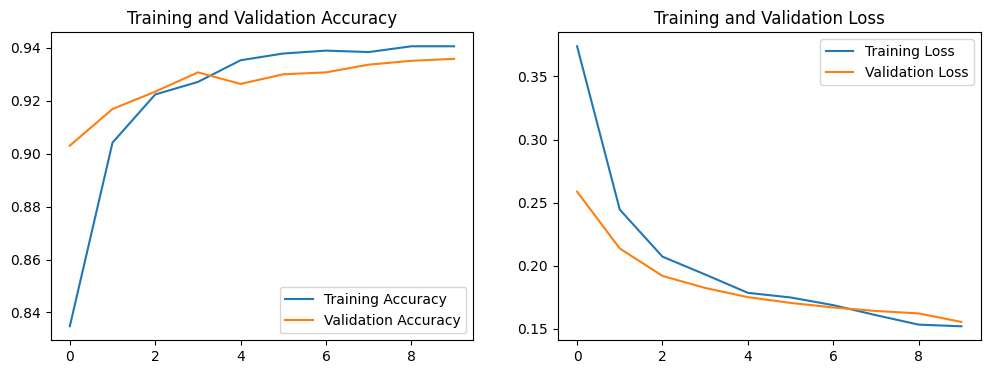

✅ Model saved as CloudRiskNet_model.keras


In [ ]:
# Import required libraries
import matplotlib.pyplot as plt

# Extract training history for plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save the trained model in the modern Keras format (.keras)
model.save("/content/CloudRiskNet_model.keras")
print("✅ Model saved as CloudRiskNet_model.keras")


### 📈 Final Model Performance: Training & Validation Curves

✅ **Accuracy Trend**:  
- Both training and validation accuracy **rise steadily** and **stabilize around 93–94%**  
- No divergence → **no overfitting** (great for small datasets!)  
- Slight dip at epoch 5 → normal fluctuation during learning  

📉 **Loss Trend**:  
- Training and validation loss **drop rapidly in early epochs** → model learns fast  
- Loss curves remain close → **good generalization**  
- Plateau after epoch 8 → model converged successfully  

⚡ **Key Takeaway for Power Grid Safety**:  
> The model achieves **high accuracy with stable performance** — ideal for operational use.  
> Even though we have class imbalance, the model learned to distinguish subtle visual cues (e.g., frost vs. dew) without biasing toward majority classes.

💾 **Model Saved**:  
✅ `CloudRiskNet_model.keras` — ready for deployment or inference on new weather images!

🌟 **Final Note**:  
This model can be integrated into early-warning systems for power grids, helping operators anticipate high-risk conditions before they cause outages.